In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import astropy.units as u
from astropy.time import Time
import sys

from tqdm import *

figures=1
plotdir='/home/ramain/packages/b1957GiantPulses/CrabWB/'

%matplotlib inline

In [54]:
def rechannelize(pulse, nchan):
    pulse = np.fft.irfft(pulse, axis=1)
    # Reshape to channels and keep polarization
    pulse = pulse.reshape(-1, 2*nchan, pulse.shape[-1])
    pulse = np.fft.rfft(pulse, axis=1)
    return pulse

def ReadPulselist(f, SNcut=1, phase0=0.5, phasewidth=0.5):
    T, SN, phase = np.loadtxt(f, dtype='string').T
    
    T = Time(T, precision=9)

    Tu, indeces = np.unique(T.isot, return_index=True)

    T = Time(Tu, precision=9)
    SN = SN[indeces].astype('float')
    phase = phase[indeces].astype('float')

    T = T[SN>SNcut]
    phase = phase[SN>SNcut]
    SN = SN[SN>SNcut]

    T = T[abs(phase-phase0) < phasewidth]
    SN = SN[abs(phase-phase0) < phasewidth]
    phase = phase[abs(phase-phase0) < phasewidth]

    return T, SN, phase

def ExtractPulse(tgp):
    dchan = np.load('/media/drive2/WbGPs/GP{0}.npy'.format(tgp.isot))
    prof = rechannelize(dchan, 32)
    peak = np.argmax(np.abs(prof).sum(-1).sum(-1))
    prof = np.roll(prof, prof.shape[0]//2 - peak, axis=0)
    dchan = rechannelize(prof, 128) 
    
    dR = np.concatenate((dchan[:,::-1,2][:,:-1], dchan[...,0][:,1:]), axis=1)
    dL = np.concatenate((dchan[:,::-1,3][:,:-1], dchan[...,1][:,1:]), axis=1)
    x = (abs(dR)**2 + abs(dL)**2)
    
    pulse = x[50:51].mean(0)
    noise = x[5:35]#.mean(0)
    bg = x[19:22].mean(0)

    GP = pulse# - bg 
    n = noise# - bg
    return GP[16:-16], noise[:,16:-16]

def ExtractArPulse(tgp):
    dchan = np.load('/media/drive2/ArGPs/GP{0}.npy'.format(tgp.isot))
    dR = np.concatenate((dchan[:,::-1,2][:,:-1], dchan[...,0][:,1:]), axis=1)
    dL = np.concatenate((dchan[:,::-1,3][:,:-1], dchan[...,1][:,1:]), axis=1)
    x = (abs(dR)**2 + abs(dL)**2)
    pulse = x[49:52].mean(0)
    noise = x[9:40]#.mean(0)
    bg = x[19:22].mean(0)
    GP = pulse# - bg 
    n = noise# - bg
    return GP[16:-16], bg[16:-16]

def ExtractBWPulse(tgp):
    dchan = np.load('/media/drive2/b1957-GPs/RGPs/GP{0}.npy'.format(tgp.isot))
    x = (abs(dchan)**2)
    pulse = x[49:51].mean(0)
    noise = x[9:11].mean(0)
    bg = x[10:13].mean(0)

    GP = pulse
    n = noise
    return GP[50:-50], noise[50:-50]

def CorrPulses(GP1, N1, GP2, N2):
    autoc = (GP1 - np.mean(GP1))  * (GP2 - np.mean(GP2))

    std1 = np.std(GP1)**2.0 - np.std(N1)**2.0
    std2 = np.std(GP2)**2.0 - np.std(N2)**2.0
    #std1 = np.std(GP1)**2.0 - np.mean(N1**2.0)
    #std2 = np.std(GP2)**2.0 - np.mean(N2**2.0)

    corr = np.mean( autoc / np.sqrt(std1 * std2))
    return corr

def FreqCorr(GP1, N1, GP2, N2):
    N = len(GP1)
    ccorr = np.zeros(N)
    std1 = np.std(GP1)**2.0 - np.std(N1)**2.0
    std2 = np.std(GP2)**2.0 - np.std(N2)**2.0
    
    for i in range(N):
        GP2roll = np.roll(GP2, i)
        autoc = (GP1 - np.mean(GP1))  * (GP2roll - np.mean(GP2))
        corr = np.mean( autoc / np.sqrt(std1 * std2))
        ccorr[i] = corr
        
    return ccorr
    
def CorrNoise(GP1, N1, GP2, N2):
    # On pulse, off pulse, and cross-term in variance
    
    mean1 = np.mean(GP1)
    meanbg1 = np.mean(N1)
    var1 = np.std(GP1)**2.0
    varbg1 =  np.std(N1)**2.0
    varct1 = 2*(mean1 - meanbg1)*meanbg1
    
    var1_corrected = var1 - varbg1 - varct1
    
    mean2 = np.mean(GP2)
    meanbg2 = np.mean(N2)
    var2 = np.std(GP2)**2.0 
    varbg2 = np.std(N2)**2.0
    varct2 = 2*(mean2 - meanbg2)*meanbg2
    
    var2_corrected = var2 - varbg2 - varct2
    
    autoc = (GP1 - mean1)  * (GP2 - mean2)
    corr = np.mean( autoc / np.sqrt(var1_corrected * var2_corrected))
    
    return corr
    
def CCorrNoise(GP1, N1, GP2, N2):
    N = len(GP1)
    ccorr = np.zeros(N)
    # On pulse, off pulse, and cross-term in variance
    
    mean1 = np.mean(GP1)
    meanbg1 = np.mean(N1)
    var1 = np.std(GP1)**2.0
    varbg1 =  np.std(N1)**2.0
    varct1 = 2*(mean1 - meanbg1)*meanbg1
    
    var1_corrected = var1 - varbg1 - varct1
    
    mean2 = np.mean(GP2)
    meanbg2 = np.mean(N2)
    var2 = np.std(GP2)**2.0 
    varbg2 = np.std(N2)**2.0
    varct2 = 2*(mean2 - meanbg2)*meanbg2
    
    var2_corrected = var2 - varbg2 - varct2

    
    for i in range(N):
        GP2roll = np.roll(GP2, i)
        autoc = (GP1 - mean1)  * (GP2roll - mean2)
        
        corr = np.mean( autoc / np.sqrt(var1_corrected * var2_corrected))
        ccorr[i] = corr
        
    return ccorr
    

In [55]:
""" MP-MP or IP-IP pairs ="""
Tcut = 30
Tbin = 1
SNcut = 50

gplist = 'gp.txt'

T, SN, phase = ReadPulselist(gplist, SNcut=SNcut, phase0=0.73, phasewidth=0.02)  #MP pairs
#T, SN, phase = ReadPulselist(gplist, SNcut=SNcut, phase0=0.15, phasewidth=0.02)  # IP pairs

l = len(T)
pairDT = np.zeros(l*l)
corr = np.zeros(l*l)
ccorr = np.zeros((l*l, 256-32))
Tu = T.unix

for i in range(l):
    for j in range(l):
        diff = Tu[i] - Tu[j]
        pairDT[i*l+j] = diff

for i in tqdm(range(l)):
    GP1, N1 = ExtractPulse(T[i])
    for j in range(l):
        if np.abs(pairDT[i*l+j]) < Tcut:
            GP2, N2 = ExtractPulse(T[j])
            corr[i*l+j] = CorrNoise(GP1, N1, GP2, N2)
            ccorr[i*l+j] = CCorrNoise(GP1, N1, GP2, N2)

DTu = pairDT[corr != 0]
corru = corr[corr != 0]
#ccorru = ccorr[ccorr != 0]

DTplot = []
Cplot = []
Cerr = []

# Bin every cycle
#for i in range(1000):  
#    DTrange = DTu[abs(DTu-i*0.0337 < 0.01]
#    crange = corru[abs(DTu-i*0.0337) < 0.01]
#    DTplot.append(i)
#    Cplot.append(np.mean(crange))
#    Cerr.append(np.std(crange))

# Bin every second
for i in range(Tcut / Tbin):  
    DTrange = DTu[abs(DTu-(i*Tbin+Tbin/2.)) < Tbin/2.-0.01]
    crange = corru[abs(DTu-(i*Tbin+Tbin/2.)) < Tbin/2.-0.01]
    DTplot.append(i+1)
    crange = crange[~np.isnan(crange)]
    Cplot.append(np.mean(crange) )
    Cerr.append(np.std(crange)/np.sqrt(len(crange)))

plt.errorbar(DTplot, Cplot, yerr=Cerr, fmt='kx')


  0%|          | 0/1142 [00:00<?, ?it/s]/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:116: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:146: RuntimeWarning: invalid value encountered in sqrt
 72%|███████▏  | 819/1142 [01:20<00:31, 10.22it/s]ERROR: ValueError: attempt to get argmax of an empty sequence [numpy.core.fromnumeric]


ValueError: attempt to get argmax of an empty sequence

 72%|███████▏  | 819/1142 [01:33<00:36,  8.76it/s]

In [57]:
T[j]

<Time object: scale='utc' format='isot' value=2015-01-11T01:22:16.000032000>

(1304164, 224) (6686, 224) (6686,)


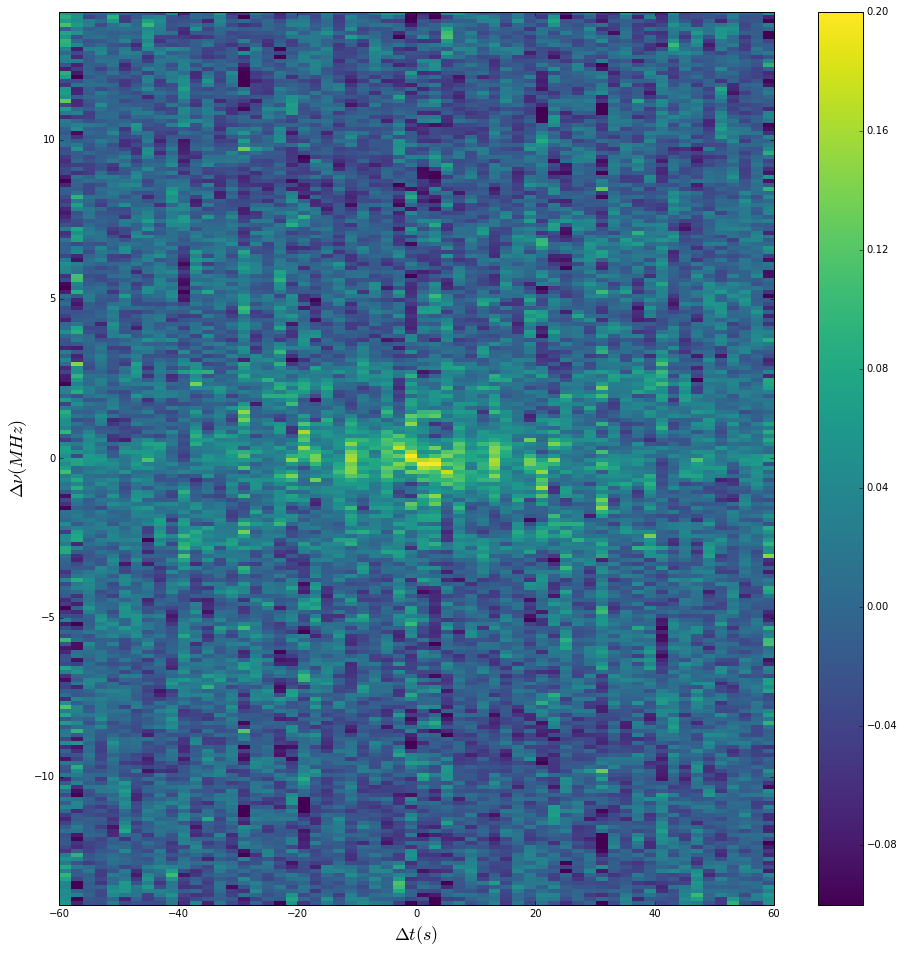

In [45]:
# Bin every second
%matplotlib inline

Tbin = 1

DTu = pairDT[corr != 0]
corru = corr[corr != 0]
ccorru = ccorr[np.argwhere(ccorr[:,0] != 0)].squeeze()

DTplot = []
Cplot = []
CCplot = []
Cerr = []

print ccorr.shape, ccorru.shape, DTu.shape

#for i in range(Tcut / Tbin):  
#    DTrange = DTu[abs(DTu-(i*Tbin+Tbin/2.)) < Tbin/2.-0.01]
#    crange = corru[abs(DTu-(i*Tbin+Tbin/2.)) < Tbin/2.-0.01]
#    ccrange = ccorru[np.argwhere(abs(DTu-(i*Tbin+Tbin/2.)) < Tbin/2.-0.01)].squeeze()
#    DTplot.append(i+1)
#    ccrange = ccrange[np.argwhere(~np.isnan(ccrange.sum(-1)))].squeeze()
#    CCplot.append(np.mean(ccrange, axis=0) )
#    Cerr.append(np.std(crange)/np.sqrt(len(crange)))

for i in range(-int(Tcut / Tbin), int(Tcut / Tbin)):
    if i == 0:
        indeces = np.argwhere( abs(DTu-(i*Tbin+Tbin/2.)) < Tbin/2.-0.01 ).squeeze()
    else:
        indeces = np.argwhere( (DTu-i*Tbin > -Tbin/2.) & (DTu-i*Tbin < Tbin/2.) ).squeeze()
    DTrange = DTu[indeces]
    ccrange = ccorru[indeces]
    ccrange = ccrange[np.argwhere(~np.isnan(ccrange.sum(-1)))].squeeze()
    CCplot.append(np.mean(ccrange, axis=0) )
    
    
CCplot = np.array(CCplot)    
CCplot = np.roll(CCplot, CCplot.shape[1]/2, axis=1)

#np.save('MPcorr-t60-dt05.npy', CCplot)

plt.figure(figsize=(16,16))
plt.imshow(CCplot.T, aspect='auto', interpolation='nearest', cmap=cm.viridis,
          extent=[-60,60,-14,14], vmax=0.2, vmin=-0.1)
plt.xlabel(r'$\Delta t (s)$', fontsize=18)
plt.ylabel(r'$\Delta \nu (MHz)$', fontsize=18)
plt.colorbar()

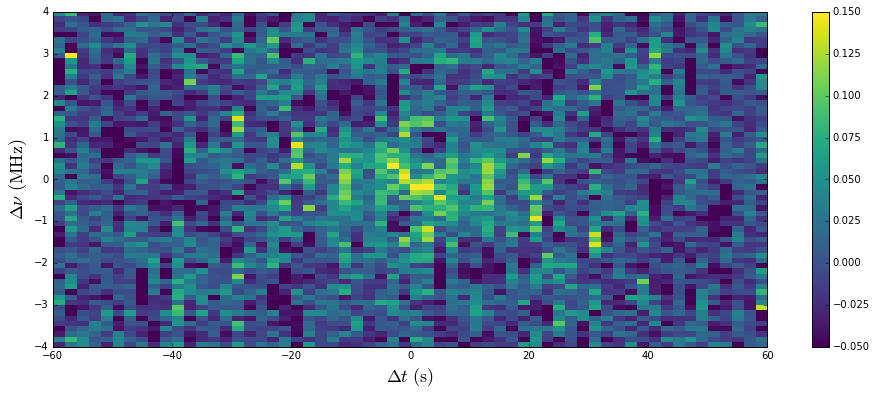

In [48]:
%matplotlib inline

CCbgsub = CCplot - CCplot[40:,:].mean(axis=0, keepdims=True)

plt.figure(figsize=(16,6))
plt.imshow( CCbgsub[:, 112-32:112+32].T, aspect='auto', interpolation='nearest', cmap=cm.viridis,
          extent=[-60,60,-4,4], vmin=-0.05, vmax=0.15)
plt.xlabel(r'$\Delta t\ \mathrm{(s)}$', fontsize=18)
plt.ylabel(r'$\Delta \nu \ \mathrm{(MHz)}$', fontsize=18)
plt.colorbar()

#if figures:
#    plt.savefig('%s/MP-MP-ccorr.pdf' % (plotdir), dpi=1000)

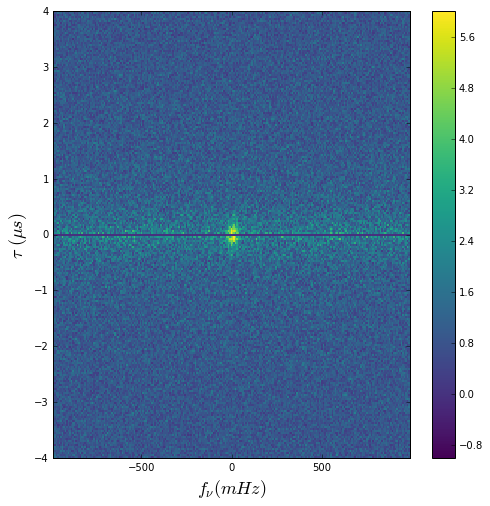

In [68]:
def plotSS(SS, vmin=-1, vmax=6, Tbin=1*u.s, fbin=16.*u.MHz/128):
    SSplot = np.sqrt(np.abs(SS))*np.sign(SS)
    tau = np.fft.fftfreq(SS.shape[1], fbin).to(u.microsecond).value
    fnu = np.fft.fftfreq(SS.shape[0], Tbin).to(u.mHz).value
    fmax = max(fnu)
    tmax = min(tau)
    plt.imshow(SSplot.T, aspect='auto', interpolation='nearest', cmap=cm.viridis, vmin=vmin, vmax=vmax,
              extent=[-fmax, fmax, tmax, -tmax])
    plt.xlabel(r'$f_{\nu} (mHz)$', fontsize=18)
    plt.ylabel(r'$\tau \ (\mu s)$', fontsize=18)
    plt.colorbar()

""" FT the Cross corr """

%matplotlib inline
plt.figure(figsize=(8, 8))

CCshift = np.fft.fftshift(CCbgsub)

SS = np.fft.fft2(CCshift)
SS = np.fft.fftshift(SS)

#plt.imshow( CCshift.T, aspect='auto', interpolation='nearest', cmap=cm.viridis)


plotSS(np.abs(SS), Tbin=0.5*u.s, vmin=-1, vmax=6)

In [26]:
%matplotlib inline
Tcut = 180
Tbin = 1
SNcut = 30

gplist = 'gp.txt'

MPT, MPSN, MPphase = ReadPulselist(gplist, SNcut=SNcut, phase0=0.73, phasewidth=0.02)
IPT, IPSN, IPphase = ReadPulselist(gplist, SNcut=SNcut, phase0=0.15, phasewidth=0.02)

l1 = len(MPT)
l2 = len(IPT)
pairDT = np.zeros(l1*l2)
corr = np.zeros(l1*l2)
IPccorr = np.zeros((l1*l2, 256-32))

MPTu = MPT.unix
IPTu = IPT.unix

for i in range(l1):
    for j in range(l2):
        #diff = np.abs(MPTu[i] - IPTu[j])
        diff = MPTu[i] - IPTu[j]
        pairDT[i*l2+j] = diff

for i in tqdm(range(l1)):
    GP1, N1 = ExtractPulse(MPT[i])
    for j in range(l2):
        if np.abs(pairDT[i*l2+j]) < Tcut:
            GP2, N2 = ExtractPulse(IPT[j])
            corr[i*l2+j] = CorrPulses(GP1, N1, GP2, N2)
            IPccorr[i*l2+j] = FreqCorr(GP1, N1, GP2, N2)            


100%|██████████| 2625/2625 [02:36<00:00, 22.01it/s]


(181, 224)
(181, 224)


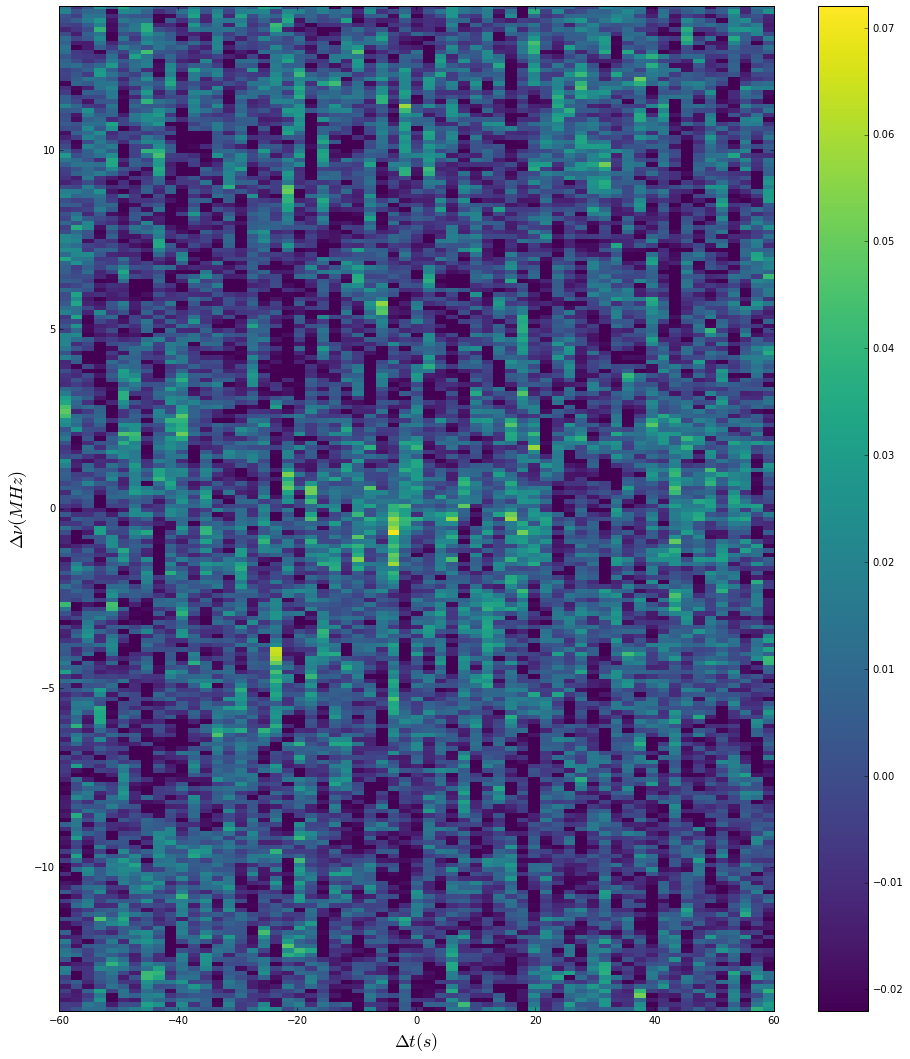

In [28]:
%matplotlib inline


# Bin every second
DTu = pairDT[corr != 0]
corru = corr[corr != 0]
IPccorru = IPccorr[np.argwhere(IPccorr[:,0] != 0)].squeeze()

#IPccorru = np.load('IPccorr.npy')
#DTu = np.load('IPDTu.npy')

Tbin = 2

#print IPccorru.shape
#print DTu.shape

DTplot = []
CCplot = []

#for i in range(Tcut / Tbin):  
#    DTrange = DTu[abs(DTu-(i*Tbin+Tbin/2.)) < Tbin/2.-0.01]
#    ccrange = IPccorru[np.argwhere(abs(DTu-(i*Tbin+Tbin/2.)) < Tbin/2.-0.01)].squeeze()
#    DTplot.append(i+1)
#    ccrange = ccrange[np.argwhere(~np.isnan(ccrange.sum(-1)))].squeeze()
#    CCplot.append(np.mean(ccrange, axis=0) )

# Allow for time asymmetry


for i in range(-int(Tcut / Tbin), int(Tcut / Tbin) + 1):  
    indeces = np.argwhere( (DTu-i*Tbin > -Tbin/2.) & (DTu-i*Tbin < Tbin/2.) ).squeeze()
    DTrange = DTu[indeces]
    ccrange = IPccorru[indeces]
    ccrange = ccrange[np.argwhere(~np.isnan(ccrange.sum(-1)))].squeeze()
    CCplot.append(np.mean(ccrange, axis=0) )
    
CCplot = np.array(CCplot)    
CCplot = np.roll(CCplot, CCplot.shape[1]/2, axis=1)

print CCplot.shape

np.save('IPcorr-t180-dt2s.npy', CCplot)

CCplot_clean = CCplot - ( CCplot[-30:].mean(axis=0) + CCplot[:30].mean(axis=0) ) / 2.

plt.figure(figsize=(16,18))

print CCplot_clean.shape

plt.imshow(CCplot_clean[60:-60].T, aspect='auto', interpolation='nearest', cmap=cm.viridis,
          extent=[-60, 60, -14, 14], vmin=-0.022, vmax=0.072)
#plt.imshow(CCplot_clean.T, aspect='auto', interpolation='nearest', cmap=cm.viridis,
#          extent=[-Tcut, Tcut, -14, 14], vmin=-0.01)

plt.xlabel(r'$\Delta t (s)$', fontsize=18)
plt.ylabel(r'$\Delta \nu (MHz)$', fontsize=18)
plt.colorbar()

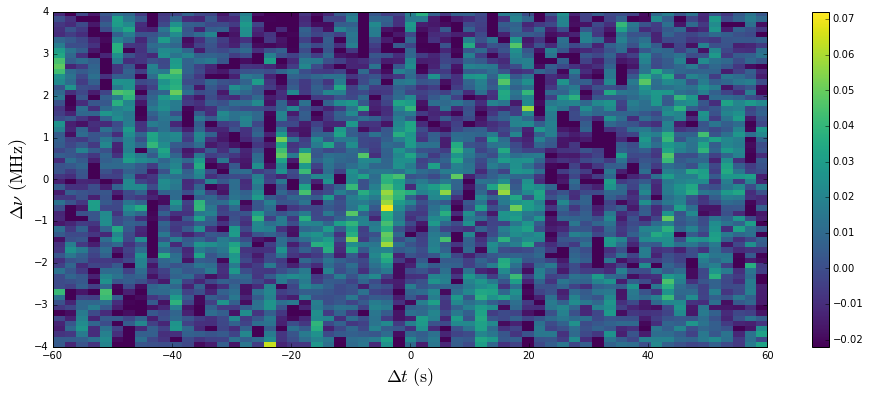

In [23]:
plt.figure(figsize=(16,6))

plt.imshow(CCplot_clean[60:-60,224//2-32:224//2+32].T, aspect='auto', interpolation='nearest', cmap=cm.viridis,
          extent=[-60, 60, -4, 4], vmin=-0.022, vmax=0.072)
#plt.imshow(CCplot_clean.T, aspect='auto', interpolation='nearest', cmap=cm.viridis,
#          extent=[-Tcut, Tcut, -14, 14], vmin=-0.01)

plt.xlabel(r'$\Delta t\ \mathrm{(s)}$', fontsize=18)
plt.ylabel(r'$\Delta \nu \ \mathrm{(MHz)}$', fontsize=18)
plt.colorbar()

if figures:
    plt.savefig('%s/MP-IP-ccorr.pdf' % (plotdir), dpi=1000)

In [332]:
%matplotlib qt

plt.figure(figsize=(10, 10))

SS = np.fft.fft2(CCplot_clean[120:-120])
SS = np.fft.fftshift(SS)

plotSS(np.abs(SS), Tbin=1*u.s, vmin=-1, vmax=6)

In [239]:
""" WB-AR Incoherent Cross-Spectrum """

Tcut = 60
Tbin = 1

gplist = 'gp.txt'

vislist = np.loadtxt('VisPairs.txt', dtype='string')

MPT = Time(vislist[:,0], precision=9)
IPT = Time(vislist[:,1], precision=5)

l1 = len(MPT)
l2 = len(IPT)

pairDT = np.zeros(l1*l2)
corr = np.zeros(l1*l2)
WAccorr = np.zeros((l1*l2, 256-32))

MPTu = MPT.unix
IPTu = IPT.unix

for i in range(l1):
    for j in range(l2):
        #diff = np.abs(MPTu[i] - IPTu[j])
        # So as not to include clock offset
        diff = MPTu[i] - MPTu[j]
        pairDT[i*l2+j] = diff

for i in tqdm(range(l1)):
    GP1, N1 = ExtractPulse(MPT[i])
    #GP1, N1 = ExtractArPulse(IPT[j])
    for j in range(l2):
        if np.abs(pairDT[i*l2+j]) < Tcut:
            GP2, N2 = ExtractArPulse(IPT[j])
            #GP2, N2 = ExtractPulse(MPT[j])
            corr[i*l2+j] = CorrPulses(GP1, N1, GP2, N2)
            WAccorr[i*l2+j] = FreqCorr(GP1, N1, GP2, N2) 


100%|██████████| 521/521 [01:25<00:00,  7.82it/s]


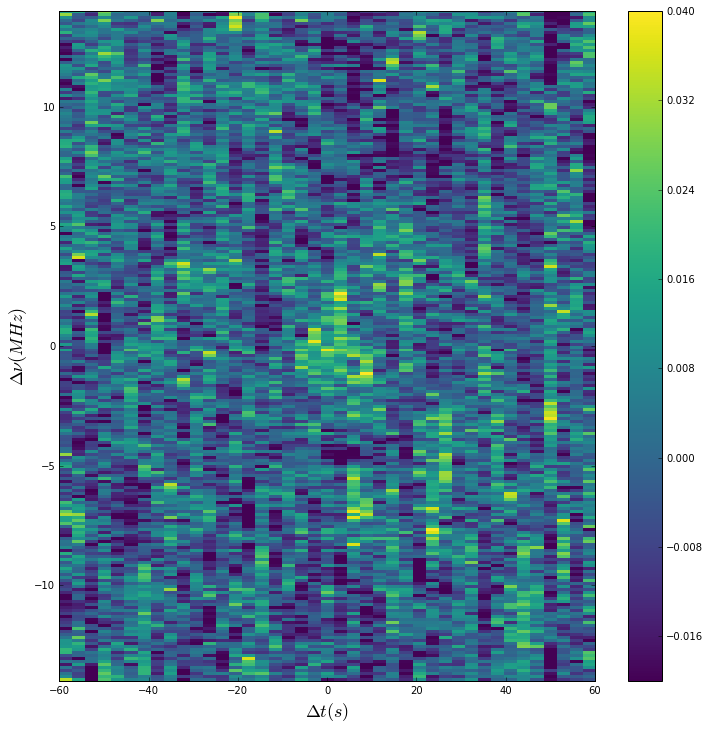

In [245]:
%matplotlib inline

DTu = pairDT[corr != 0]
corru = corr[corr != 0]
WAccorru = WAccorr[np.argwhere(WAccorr[:,0] != 0)].squeeze()

Tbin = 3

DTplot = []
CCplot = []

for i in range(-int(Tcut / Tbin), int(Tcut / Tbin) + 1):
    if i == 0:
        indeces = np.argwhere( abs(DTu-(i*Tbin+Tbin/2.)) < Tbin/2.-0.01 ).squeeze()
    else:
        indeces = np.argwhere( (DTu-i*Tbin > -Tbin/2.) & (DTu-i*Tbin < Tbin/2.) ).squeeze()
    DTrange = DTu[indeces]
    ccrange = WAccorru[indeces]
    ccrange = ccrange[np.argwhere(~np.isnan(ccrange.sum(-1)))].squeeze()
    CCplot.append(np.mean(ccrange, axis=0) )
    
CCplot = np.array(CCplot)    
CCplot = np.roll(CCplot, CCplot.shape[1]/2, axis=1)

CCplot_clean = CCplot - ( CCplot[-10:].mean(axis=0) + CCplot[:10].mean(axis=0) ) / 2.

plt.figure(figsize=(12,12))

plt.imshow(CCplot_clean.T, aspect='auto', interpolation='nearest', cmap=cm.viridis,
          extent=[-60, 60, -14, 14], vmin=-0.02, vmax=0.04)

plt.xlabel(r'$\Delta t (s)$', fontsize=18)
plt.ylabel(r'$\Delta \nu (MHz)$', fontsize=18)
plt.colorbar()

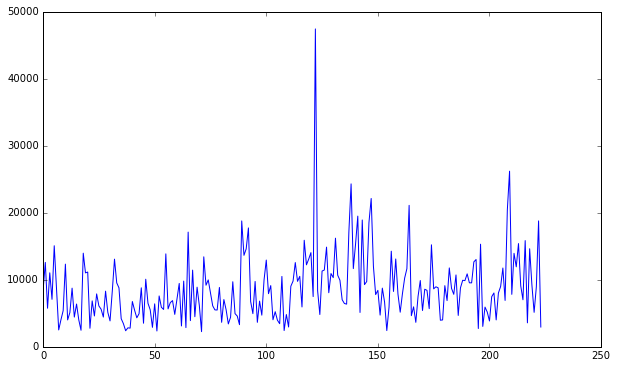

In [233]:
plt.figure(figsize=(10,6))
plt.plot(GP2)

In [260]:
""" B1957 Incoherent Cross-Spectrum """

def ReadBQPulselist(f, SNcut=15, phase0=0.5, phasewidth=0.5):
    T, SN, phase = np.loadtxt(f, dtype='string').T
    
    T = Time(T, precision=5)

    Tu, indeces = np.unique(T.isot, return_index=True)

    T = Time(Tu, precision=5)
    SN = SN[indeces].astype('float')
    phase = phase[indeces].astype('float')

    T = T[SN>SNcut]
    phase = phase[SN>SNcut]
    SN = SN[SN>SNcut]

    T = T[abs(phase-phase0) < phasewidth]
    SN = SN[abs(phase-phase0) < phasewidth]
    phase = phase[abs(phase-phase0) < phasewidth]
    return T, SN, phase

Tcut = 180
Tbin = 1

vislist = np.loadtxt('/home/ramain/packages/scint_analysis/b1957_GPs/gp_RCP_SN12clean.txt', dtype='string')

MPT = Time(vislist[:,0], precision=5)

l = len(MPT)

pairDT = np.zeros(l*l)
corr = np.zeros(l*l)
BWccorr = np.zeros((l*l, 668))

MPTu = MPT.unix

for i in range(l):
    for j in range(l):
        #diff = np.abs(MPTu[i] - IPTu[j])
        diff = MPTu[i] - MPTu[j]
        pairDT[i*l+j] = diff

for i in tqdm(range(l)):
    GP1, N1 = ExtractBWPulse(MPT[i])
    #GP1, N1 = ExtractArPulse(IPT[j])
    for j in range(l):
        if np.abs(pairDT[i*l+j]) < Tcut:
            #GP2, N2 = ExtractArPulse(IPT[j])
            GP2, N2 = ExtractBWPulse(MPT[j])
            corr[i*l+j] = CorrPulses(GP1, N1, GP2, N2)
            BWccorr[i*l+j] = FreqCorr(GP1, N1, GP2, N2) 

100%|██████████| 320/320 [02:41<00:00,  6.07it/s]


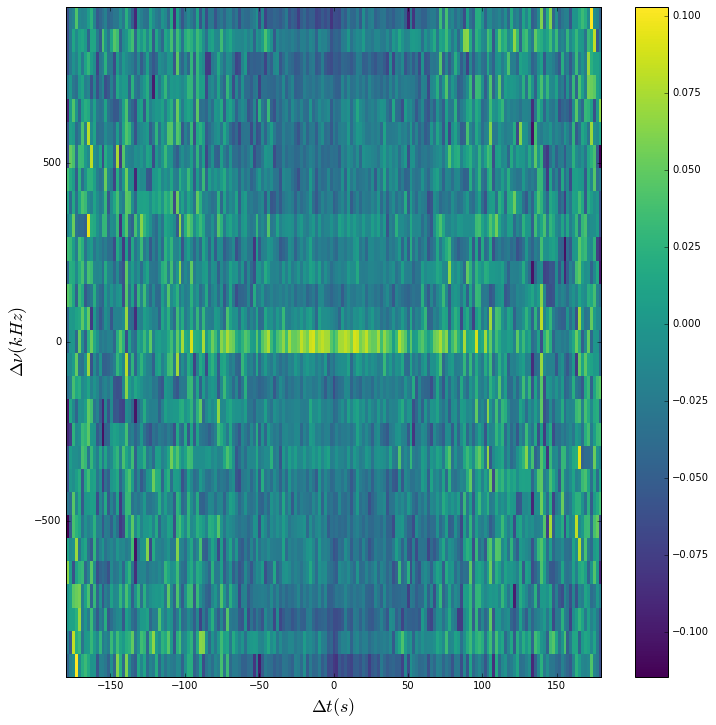

In [273]:
%matplotlib inline

DTu = pairDT[corr != 0]
corru = corr[corr != 0]
BWccorru = BWccorr[np.argwhere(BWccorr[:,0] != 0)].squeeze()

Tbin = 2

DTplot = []
CCplot = []

for i in range(-int(Tcut / Tbin), int(Tcut / Tbin) + 1):
    if i == 0:
        indeces = np.argwhere( abs(DTu-(i*Tbin+Tbin/2.)) < Tbin/2.-0.01 ).squeeze()
    else:
        indeces = np.argwhere( (DTu-i*Tbin > -Tbin/2.) & (DTu-i*Tbin < Tbin/2.) ).squeeze()
    DTrange = DTu[indeces]
    ccrange = BWccorru[indeces]
    ccrange = ccrange[np.argwhere(~np.isnan(ccrange.sum(-1)))].squeeze()
    CCplot.append(np.mean(ccrange, axis=0) )
    
CCplot = np.array(CCplot)    
CCplot = np.roll(CCplot, CCplot.shape[1]/2, axis=1)

CCplot_clean = CCplot - ( CCplot[-10:].mean(axis=0) + CCplot[:10].mean(axis=0) ) / 2.

plt.figure(figsize=(12,12))


plt.imshow(CCplot_clean[:,320:349].T, aspect='auto', interpolation='nearest', cmap=cm.viridis,
          extent=[-180,180,62.5*(-15), 62.5*15])

plt.xlabel(r'$\Delta t (s)$', fontsize=18)
plt.ylabel(r'$\Delta \nu (kHz)$', fontsize=18)
plt.colorbar()

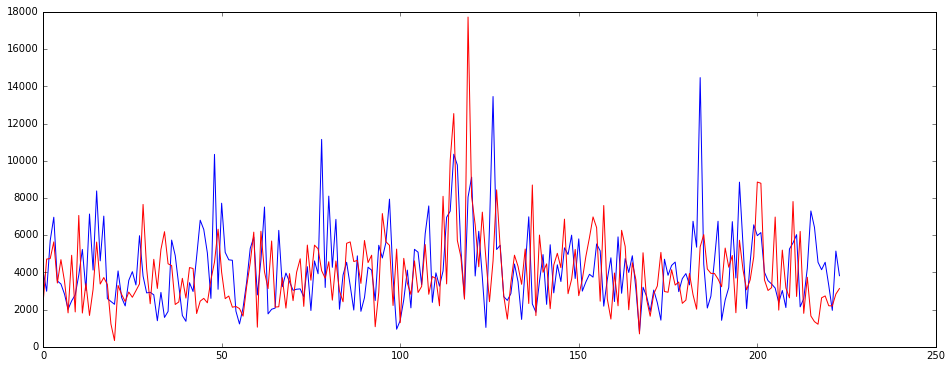

In [213]:
plt.figure(figsize=(16,6))

pltindex = 42

GP1, N1 = ExtractPulse(MPT[pltindex])
GP2, N2 = ExtractArPulse(IPT[pltindex])

plt.plot(GP1)
plt.plot(GP2, 'r')

In [127]:
""" Load Correlation Arrays for Plotting Purposes """

%matplotlib inline

MPplot = np.load('MPcorr-t60-dt05.npy')
IPplot = np.load('IPcorr-t180-dt2s.npy')


MPplot_clean = MPplot - ( MPplot[-30:].mean(axis=0) + MPplot[:30].mean(axis=0) ) / 2.
IPplot_clean = IPplot - ( IPplot[-30:].mean(axis=0) + IPplot[:30].mean(axis=0) ) / 2.
IPplot_clean = IPplot_clean[60:-60]

# bin for plotting purposes
MPplot_clean=MPplot_clean.reshape(-1, 2, MPplot_clean.shape[-1]).mean(1)
IPplot_clean=IPplot_clean.reshape(IPplot_clean.shape[0], -1, 2).mean(-1)

print MPplot_clean.shape


(120, 224)


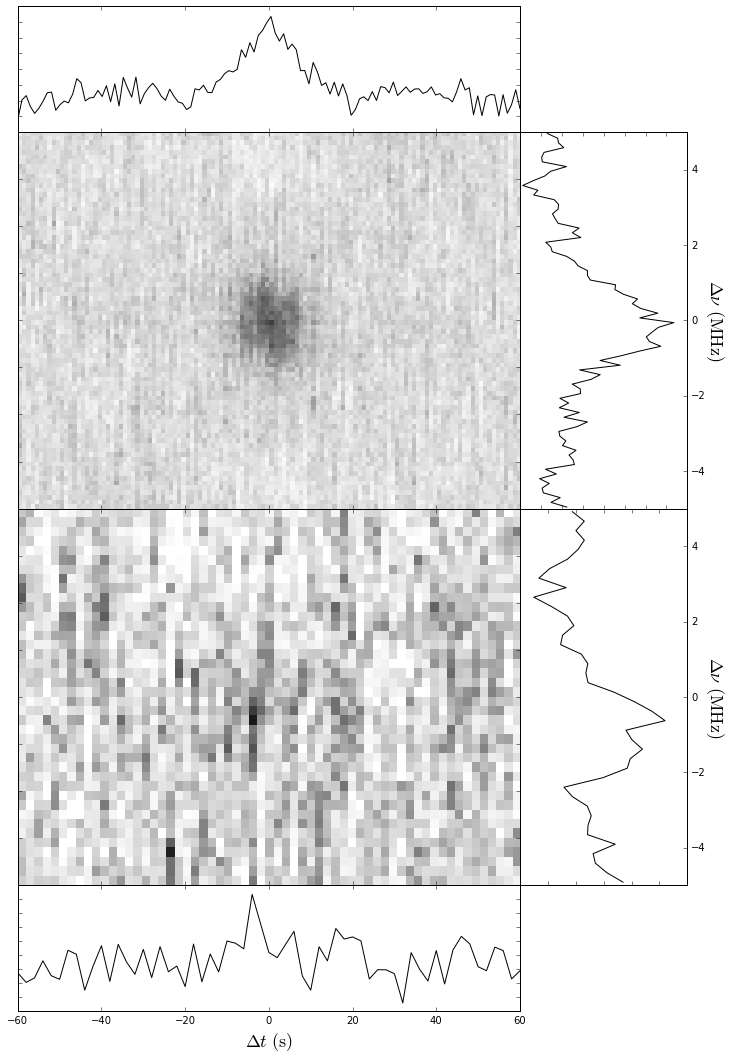

In [437]:
""" Big Mosaic of Pulse Correlations """

MPtplot = np.linspace(-60,60, MPplot_clean.shape[0])
IPtplot = np.linspace(-60,60, IPplot_clean.shape[0])

MPfplot = np.linspace(-14,14, MPplot_clean.shape[1])
IPfplot = np.linspace(-14,14, IPplot_clean.shape[1])

f = plt.figure(figsize=(12,18))

ax1 = plt.subplot2grid((8,4), (0,0), colspan=3)
ax2 = plt.subplot2grid((8,4), (1,0), colspan=3, rowspan=3)
ax3 = plt.subplot2grid((8,4), (4,0), colspan=3, rowspan=3)
ax4 = plt.subplot2grid((8,4), (7,0), colspan=3)
ax5 = plt.subplot2grid((8,4), (1,3), rowspan=3)
ax6 = plt.subplot2grid((8,4), (4,3), rowspan=3)

f.subplots_adjust(hspace=0)
f.subplots_adjust(wspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:3]], visible=False)
plt.setp([a.get_xticklabels() for a in f.axes[-2:]], visible=False)

plt.setp([a.get_yticklabels() for a in f.axes[:-2]], visible=False)

ax2.imshow( MPplot_clean[:, 112-40:112+40].T, aspect='auto', interpolation='nearest', 
           cmap=cm.Greys, extent=[-60,60,-4,4], vmin=-0.022, vmax=0.072)
ax3.imshow( IPplot_clean[:,112//2-40//2:112//2+40//2].T, aspect='auto', interpolation='nearest', 
           cmap=cm.Greys, extent=[-60,60,-4,4], vmin=-0.022, vmax=0.072)

ax1.plot(MPtplot, MPplot_clean[:,112], 'k-', drawstyle='step')
ax4.plot(IPtplot, IPplot_clean[:,56:59].mean(-1), 'k-')
ax4.set_xlabel(r'$\Delta t\ \mathrm{(s)}$', fontsize=18)


ax5.plot(MPplot_clean[MPplot_clean.shape[0]//2,112-40:112+40][::-1], MPfplot[112-40:112+40], 'k-')
ax6.plot(IPplot_clean[IPplot_clean.shape[0]//2-2 ,112//2-40//2:112//2+40//2][::-1],
         IPfplot[112//2-40//2:112//2+40//2], 'k-')

ax5.yaxis.tick_right()
ax6.yaxis.tick_right()
ax5.set_ylabel(r'$\Delta \nu\ \mathrm{(MHz)}$', fontsize=18, labelpad=20, rotation=270)
ax6.set_ylabel(r'$\Delta \nu\ \mathrm{(MHz)}$', fontsize=18, labelpad=20, rotation=270)
ax5.yaxis.set_label_position('right')
ax6.yaxis.set_label_position('right')
ax5.set_ylim(-5,5)
ax6.set_ylim(-5,5)

if figures:
    plt.savefig('%sACF.pdf' % (plotdir))
    

In [417]:
MPplot_clean[:,112].shape

(120,)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide


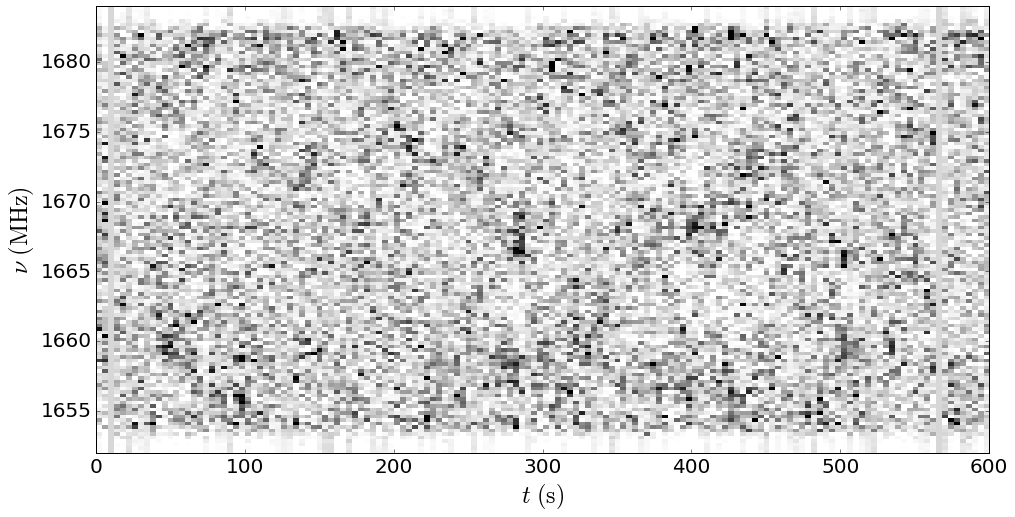

In [403]:
#f = np.load('MPdyn4sbin.npy')
#ic = np.load('MPnoise4sbin.npy')
%matplotlib inline

MPdyn = (f - f.mean(axis=1, keepdims=True)) / f.std(axis=1, keepdims=True)
MPdyn[np.isnan(MPdyn)]=0
plt.figure(figsize=(16,8))

MPdyn_bin = MPdyn.reshape(MPdyn.shape[0],-1,2).mean(-1)
MPdyn_bin = MPdyn_bin[:1200].reshape(-1,2, MPdyn_bin.shape[1]).mean(1)

plt.imshow(MPdyn_bin[440:590].T, interpolation='nearest', cmap=cm.Greys, vmin=-0.6, vmax=1.7,
           aspect='auto', extent=[0,600,1652,1652+32])
#[900+300:900+600-10]

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.xlabel(r'$t\ \mathrm{(s)}$', fontsize=24)
plt.ylabel(r'$\nu\ \mathrm{(MHz)}$', fontsize=24)

if figures:
    plt.savefig('%sMPdyn.pdf' % (plotdir),  dpi=1000)

In [280]:
with open('gplistSN30.txt','w') as f:
    for i in range(len(T)):
        f.write("%s %s %s \n" % (T[i].isot, SN[i], phase[i]))
        


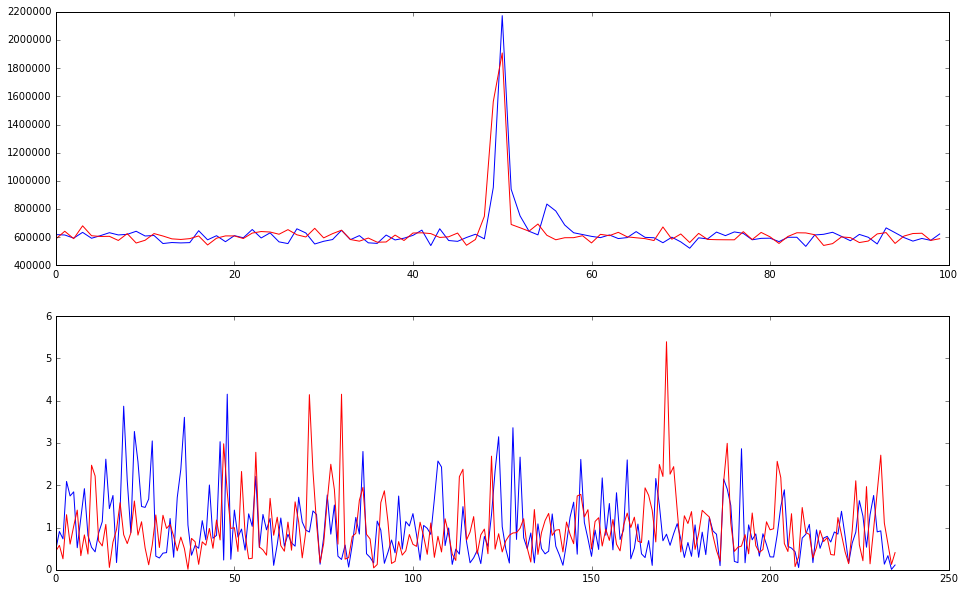

In [349]:
plt.figure(figsize=(16,10))

t1 = Time('2015-01-10T22:00:47.539736000', precision=9)
t2 = Time('2015-01-10T22:00:47.842968000', precision=9)

t1 = Time('2015-01-10T22:47:10.341088000', precision=9)
t2 = Time('2015-01-10T22:47:10.678112000', precision=9) 

p1 = ReadRechan(t1)
p2 = ReadRechan(t2)

plt.subplot(211)
plt.plot(p1.sum(1))
plt.plot(p2.sum(1),'r')

plt.subplot(212)
gp1 = p2[49, 10:-10]
gp2 = p2[50, 10:-10]

#gp2 = p2[50, 5:-5]

plt.plot(gp1 / gp1.mean())
plt.plot(gp2 / gp2.mean(), 'r')


In [438]:
def rechannelize(pulse, nchan):
    pulse = np.fft.irfft(pulse, axis=1)
    # Reshape to channels and keep polarization
    pulse = pulse.reshape(-1, 2*nchan, pulse.shape[-1])
    pulse = np.fft.rfft(pulse, axis=1)
    return pulse
    
def ReadRechan(tgp):
    dchan = np.load('/media/drive2/WbGPs/GP{0}.npy'.format(tgp.isot))
    prof = rechannelize(dchan, 32)
    peak = np.argmax(np.abs(prof).sum(-1).sum(-1))
    prof = np.roll(prof, prof.shape[0]//2 - peak, axis=0)
    dchan = rechannelize(prof, 128) 
    
    dR = np.concatenate((dchan[:,::-1,2][:,:-1], dchan[...,0][:,1:]), axis=1)
    dL = np.concatenate((dchan[:,::-1,3][:,:-1], dchan[...,1][:,1:]), axis=1)
    x = (abs(dR)**2 + abs(dL)**2)
    return x

def ReadP(tgp):
    dchan = np.load('/media/drive2/WbGPs/GP{0}.npy'.format(tgp.isot))
    dR = np.concatenate((dchan[:,::-1,2][:,:-1], dchan[...,0][:,1:]), axis=1)
    dL = np.concatenate((dchan[:,::-1,3][:,:-1], dchan[...,1][:,1:]), axis=1)
    x = (abs(dR)**2 + abs(dL)**2)
    return x

100%|██████████| 13037/13037 [02:02<00:00, 106.86it/s]


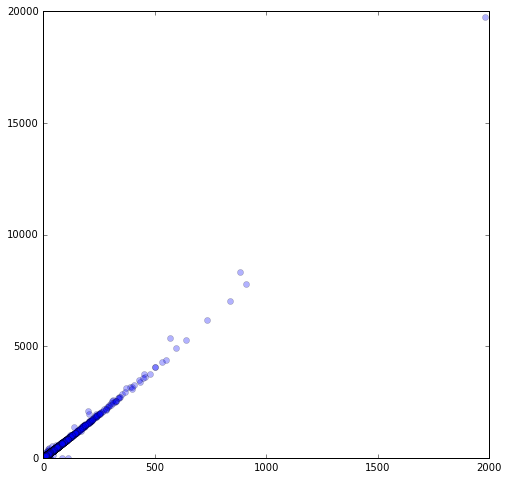

In [454]:
gplist = 'gp.txt'
T, SN, phase = ReadPulselist(gplist, SNcut=10, phase0=0.73, phasewidth=0.02)  #MP pairs
Jy = np.zeros_like(T)
Tsys = 165

for i in tqdm(range(len(T))):
    x = ReadP(T[i])
    xp = x.mean(-1)
    x_Tsys = xp / np.median(xp) - 1
    try:
        x_Jy = x_Tsys[50] * Tsys
    except:
        x_Jy = 0
    Jy[i] = x_Jy

plt.figure(figsize=(8,8))
plt.plot(SN, Jy, 'bo', alpha=0.3)
#plt.yscale('log')
#plt.xscale('log')


7.57072254431


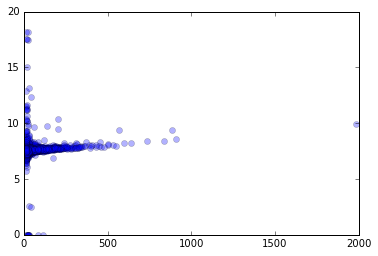

In [459]:
plt.plot(SN, Jy/SN, 'bo', alpha=0.3)

JyConv = np.mean(Jy/SN)
print JyConv
